In [16]:
import os
import librosa
import matplotlib
import scipy 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from scipy.signal import lfilter

import soundfile as sf

import phast
import abt

from matlab import MatlabData
from utils import create_neurogram, bin_over_y
from plotting import plot_pulse_train_stats

In [17]:
FS = 17400
import glob
PATH = glob.glob("/home/nobeljpde1/hearing_model/data/data/original/27*")[0]
# PATH = abt.sounds["violin"]
# PATH = "/home/nobeljpde1/abt/src/abt/data/sounds/violin.wav"
NAME = os.path.basename(PATH).split(".")[0]
OUTPUT_NAME = f"{NAME}_reconstructed_cs"

N_MELS = 128
N_FFT = 512
N_HOP = 32

MIN_FREQ = 450
MAX_FREQ = 5500

MEL_SCALE = librosa.filters.mel_frequencies(N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ) 

MAT = MatlabData.read()
CS = True

IDET = MAT.I_det[:, 4::9] if not CS else MAT.I_det

IDET_FILT = np.zeros(MAT.I_det.shape)
for e in range(135):
    IDET_FILT[:, e] = scipy.signal.savgol_filter((MAT.I_det[:, e]), 64, 2) 

IDET = IDET_FILT 

scaling_factor = 1.2
n_trials = 20
n_rep = 1

pulse_train, audio_signal = abt.wav_to_electrodogram(
    PATH, 
    current_steering=CS, 
    charge_balanced=False,  
    virtual_channels=True,
    apply_audiomixer=False,
    ramp_type = 'cs',
    M=(MAT.M * 1e6) / scaling_factor,
    T=(MAT.T * 1e6) / scaling_factor,
    Fs = FS,
    stim_db = 65.0,
    ramp_duration=0.01,
    n_rep=n_rep,
    maxModDepth=0.
)
audio_signal = audio_signal[0]#[start_st:]
duration = len(audio_signal) * (1 / FS)

S = librosa.feature.melspectrogram(y=audio_signal, sr=FS, n_fft=N_FFT, hop_length=N_HOP, n_mels=N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ)
ref_db = np.max(S)
print(S.shape)
print(duration)

# S_dB = librosa.power_to_db(S, ref=np.max)
# img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=FS, n_fft=N_FFT, hop_length=N_HOP, fmin=MIN_FREQ, fmax=MAX_FREQ)

(128, 5438)
10.0


array([], shape=(0, 2), dtype=int64)

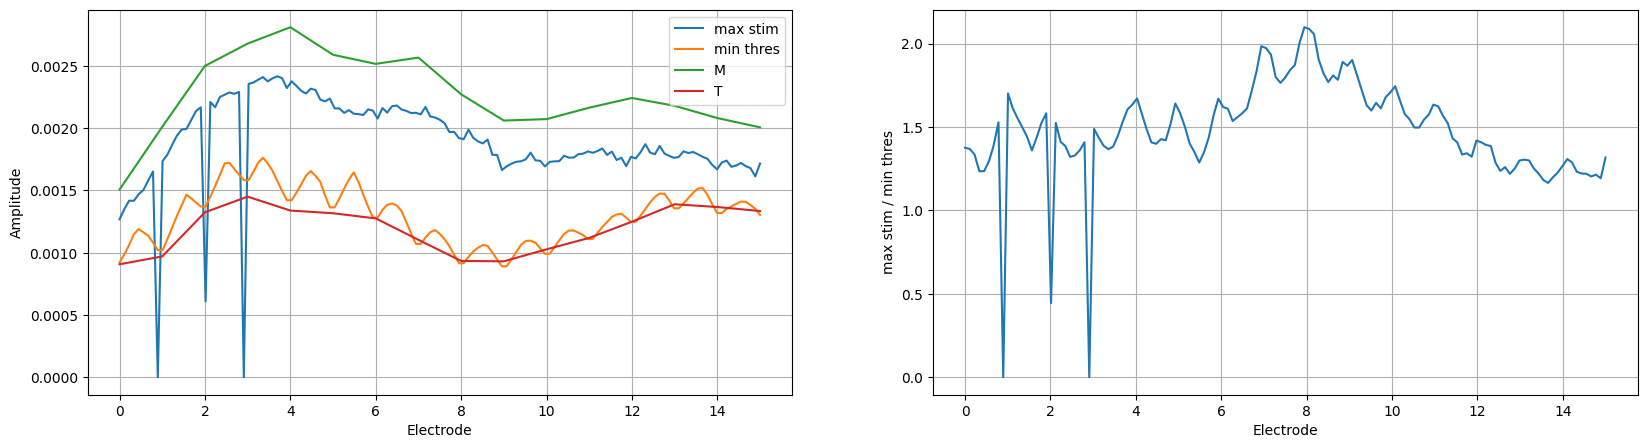

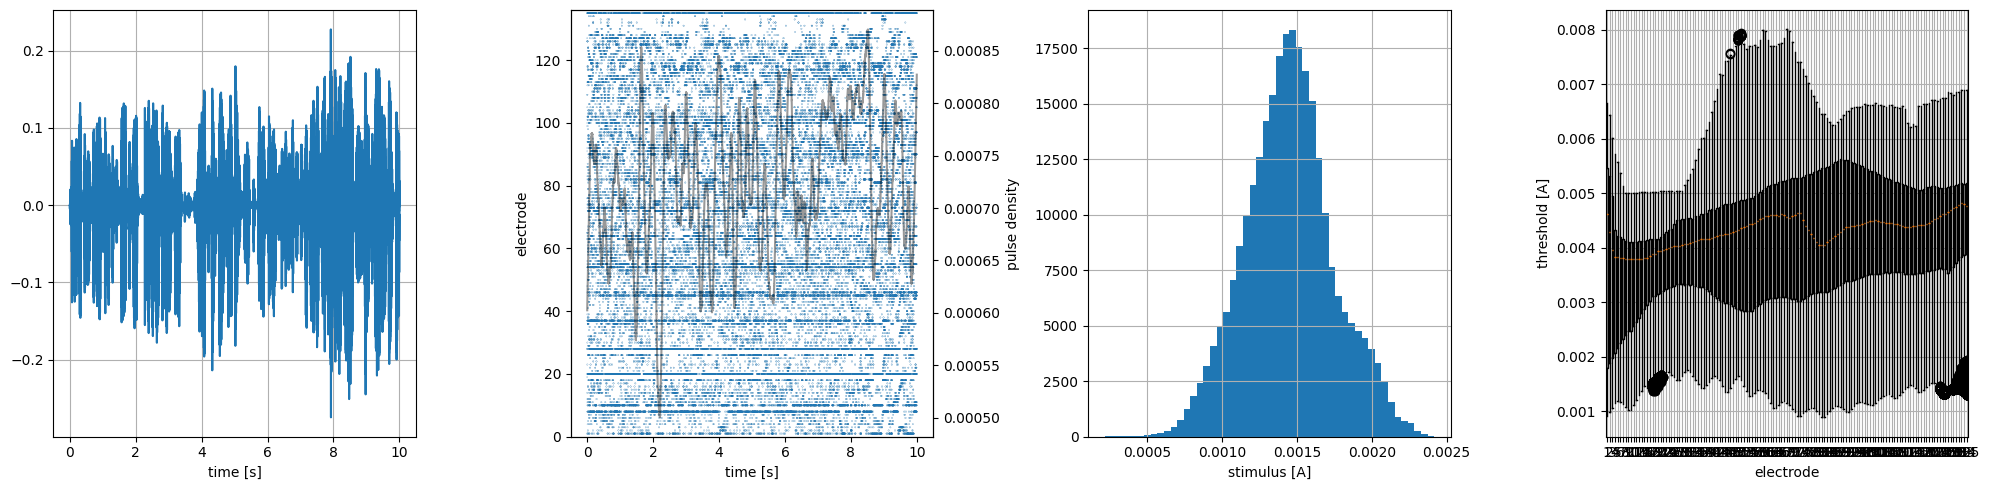

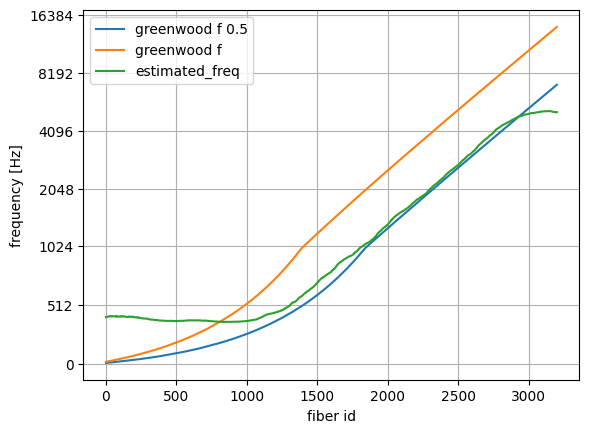

In [18]:
rep_time = pulse_train.shape[1] // n_rep
start_pt = (1 - n_rep) * rep_time
start_st = (1 - n_rep) * len(audio_signal) // n_rep
pulse_train = pulse_train#[:, start_pt:]
audio_signal = audio_signal#[start_st:]

# pulse_train *= scaling_factor

audio_duration = len(audio_signal) * (1 / FS)
duration = pulse_train.shape[1] * MAT.pw

cycle = 2 * 15
cycle_time = cycle * 18e-6
n_channels = pulse_train.shape[0]

plot_pulse_train_stats(pulse_train, audio_signal, MAT, IDET, FS) 

channel_freq = abt.utils.virtual_channel_frequencies(n_channels, MAX_FREQ + 500)

power = 25
w = (-IDET / IDET.sum(axis=1).reshape(-1, 1)) + (2 / len(channel_freq))
w = np.power(w, power) / np.power(w, power).sum(axis=1).reshape(-1, 1)

estimated_freq = w @ channel_freq
plt.figure()
plt.plot(MAT.greenwood_f * .5, label="greenwood f 0.5")
plt.plot(MAT.greenwood_f, label="greenwood f")
plt.plot(estimated_freq, label="estimated_freq")
abt.utils.frequency_ax()
plt.xlabel("fiber id")
plt.legend()
plt.grid()


fiber_freq = estimated_freq#MAT.greenwood_f * 0.5

values, counts = np.unique_counts(np.digitize(fiber_freq, MEL_SCALE))

missing_freq_bins = np.array(list(set(range(80)) - set(values)), dtype=int)

np.c_[missing_freq_bins, MEL_SCALE[missing_freq_bins]].astype(int)



(135, 5438)

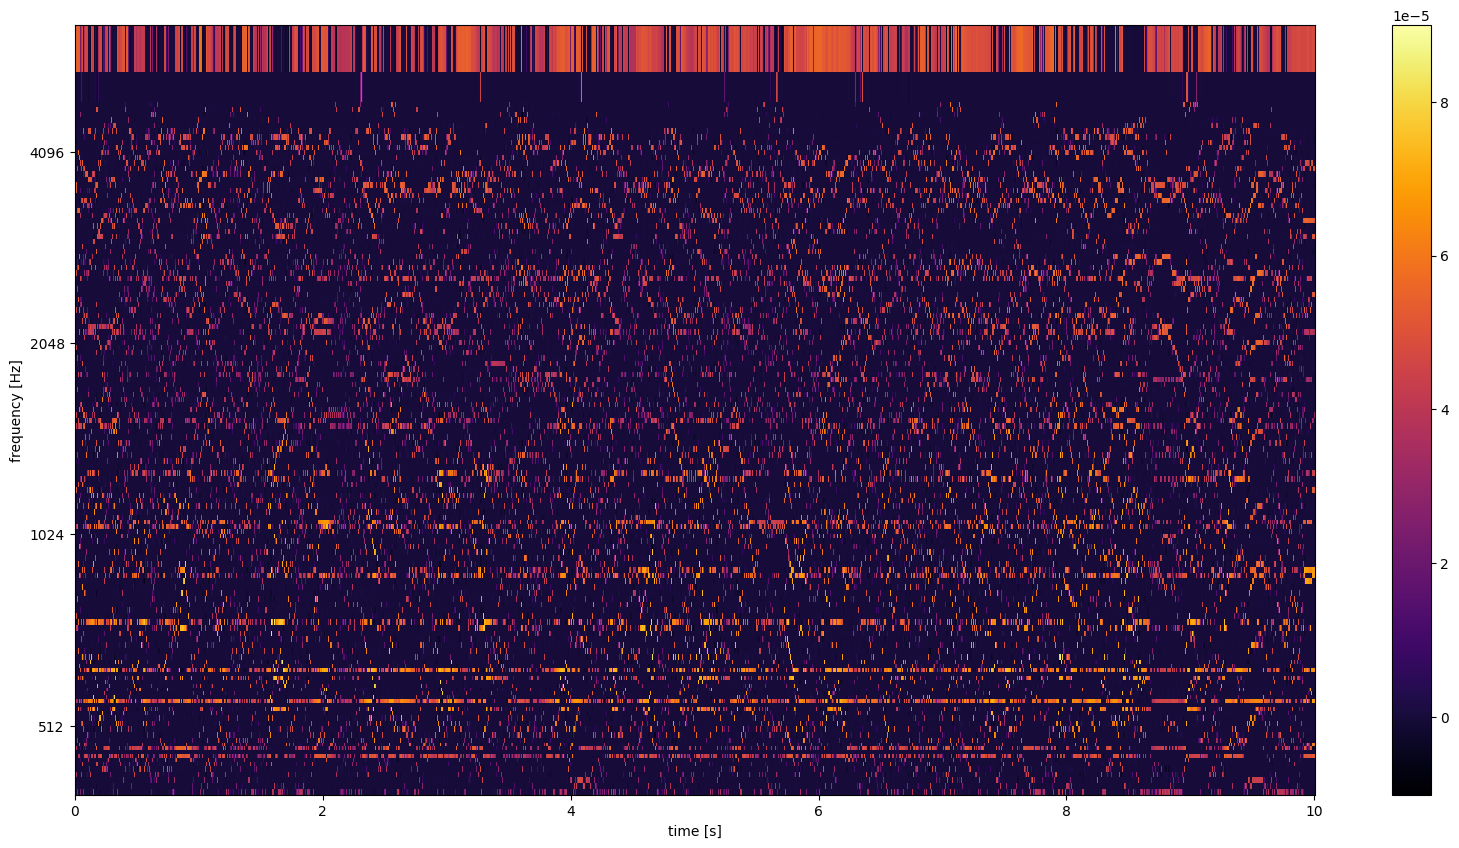

In [19]:
f, ax = plt.subplots(figsize=(20, 10))
spt = abt.utils.apply_filter(pulse_train, "hann", 8*15, 2*15, resample_to=S.shape[1], scale=False)
t = np.linspace(0, duration, len(spt[0]))
abt.utils.plot_heatmap(t, channel_freq, spt, show_bands=False, fig=f, ax=ax)
spt.shape

In [20]:
stimulus = phast.PulseTrain(pulse_train, time_step=MAT.pw)

selected_fibers = np.arange(3200)

fibers = []
for fiber_idx in selected_fibers:
    fibers.append(
        phast.Fiber(
            i_det=IDET[fiber_idx],
            spatial_constant=MAT.spatial_factor(fiber_idx, IDET),
            sigma=MAT.sigma(fiber_idx, IDET),  
            sigma_rs = 0.04, 
            fiber_id=fiber_idx,
            store_stats=False,
            refractory_period = phast.RefractoryPeriod(
                absolute_refractory_period = 4e-4,
                relative_refractory_period = 8e-4,
                sigma_absolute_refractory_period = 0.1e-3,
                sigma_relative_refractory_period = 0.5e-3
            ),
            decay = phast.LeakyIntegratorDecay(
                accommodation_amplitude=0.072, 
                adaptation_amplitude=7.142, 
                accommodation_rate=0.014,
                adaptation_rate=19.996,
                sigma_amp = 0.6e-2, 
                sigma_rate = 0.6e-2, 
            )
        )
    )
    

fiber_stats = phast.phast(fibers, stimulus, n_trials = n_trials, n_jobs=-1)

BINSIZE = MAT.pw * 2
ng = phast.Neurogram(fiber_stats, BINSIZE, duration, MAT.pw)  

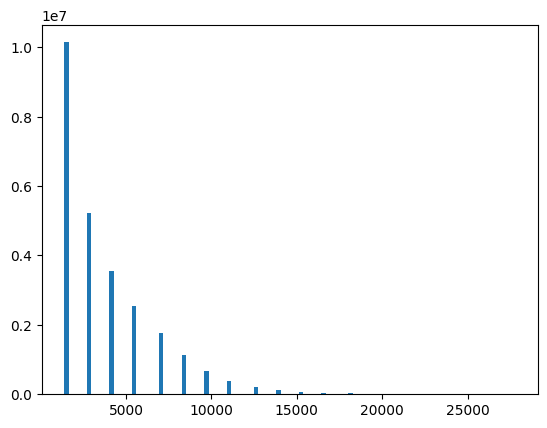

In [21]:
ng_data = ng.data / n_trials / BINSIZE
# ng_data = np.power(ng_data,2)
# ng_data = librosa.amplitude_to_db(ng_data / n_trials, ref=.0)
zero = ng_data[0, 0]

# e = np.log(ng_data)
# ng_data = e / e.sum()

plt.hist(ng_data[ng_data != zero], bins=100);

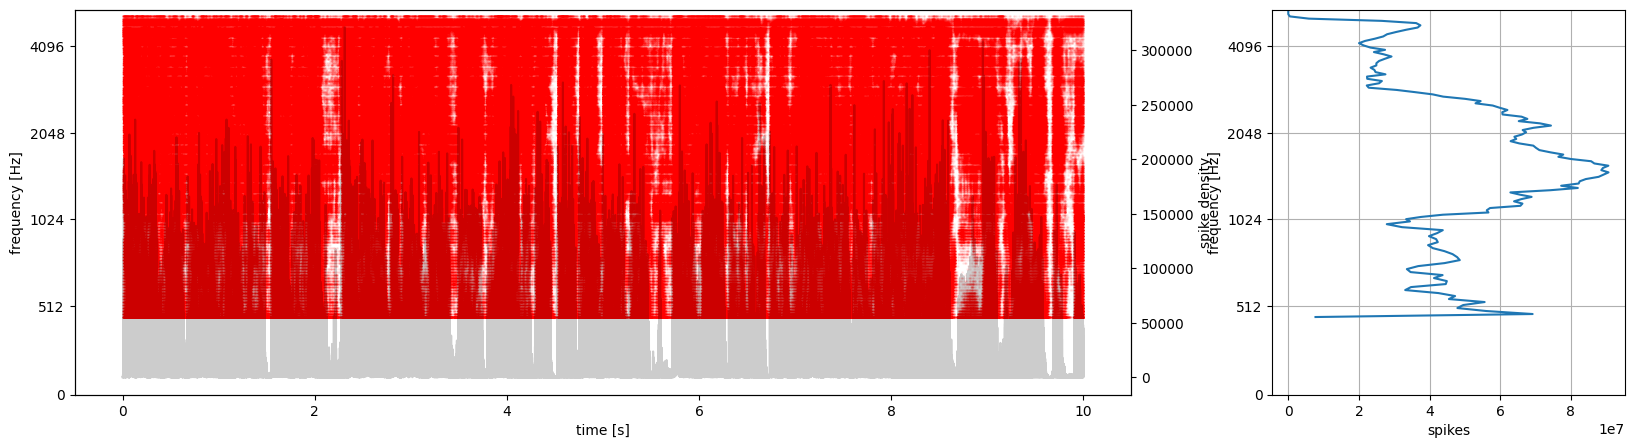

In [22]:
def q(*args, **kwargs):
    return np.quantile(*args, q=.90, **kwargs)

neurogram_freq_bin = bin_over_y(ng_data, fiber_freq, MEL_SCALE, agg=np.mean)
# neurogram_freq_bin = abt.utils.smooth(neurogram_freq_bin.T, window_size=4, hop_length=1).T

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), width_ratios=[3, 1])
for i in range(N_MELS):
    x = np.where(neurogram_freq_bin[i])[0]
    ax1.scatter(x * BINSIZE, MEL_SCALE[i] * np.ones(len(x)), color="red", alpha=.05, s=1)
    
density = neurogram_freq_bin.sum(axis=0)
ax3 = ax1.twinx()
ax3.plot(np.arange(len(density)) * BINSIZE, density, alpha=.2, color="black", zorder=-1)
ax3.set_ylabel("spike density")
      
ax2.plot(neurogram_freq_bin.sum(axis=1), MEL_SCALE)
ax2.grid()
ax2.set_xlabel("spikes")
abt.utils.frequency_ax(ax2)
abt.utils.time_vs_freq(ax1)
ax2.set_ylim(0, MAX_FREQ)
ax1.set_ylim(0, MAX_FREQ);     


(128, 5438)

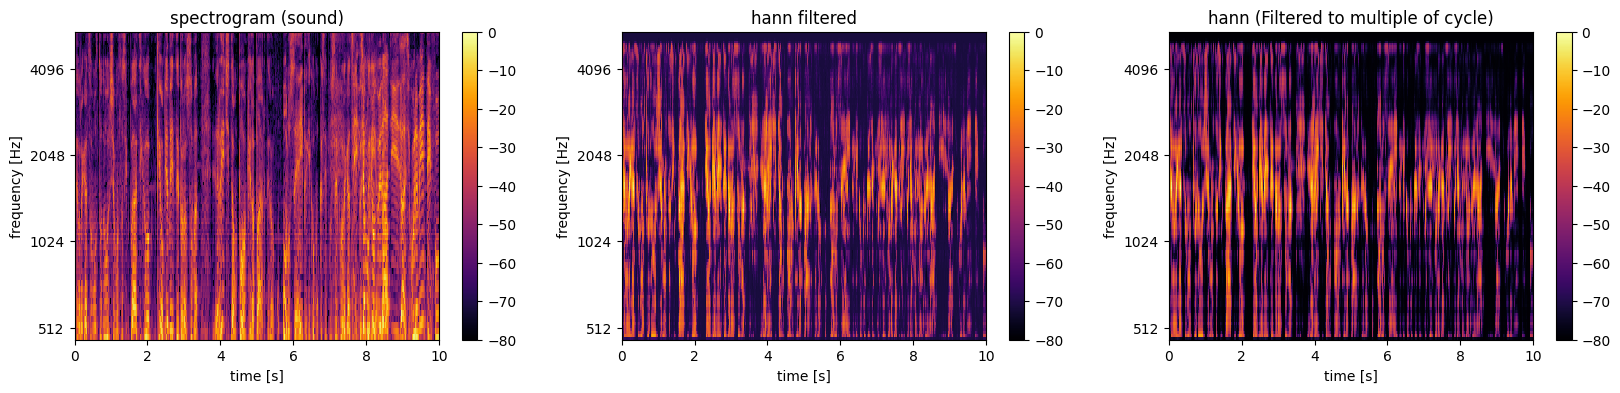

In [23]:
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 4))

S_db = librosa.power_to_db(S, ref=np.max)
ts = np.linspace(0, duration, len(S_db[0]))

abt.utils.plot_heatmap(ts, MEL_SCALE, S_db, ax0, f, show_bands=False)
ax0.set_title("spectrogram (sound)")

filtered_data = abt.utils.apply_filter(neurogram_freq_bin, window_size=1, hop_length=1, clip_outliers=.999, resample_to=S.shape[1])

t = np.linspace(0, duration, len(filtered_data[0]))
abt.utils.plot_heatmap(t, MEL_SCALE, filtered_data, ax=ax1, fig=f, show_bands=False)
ax1.set_title("hann filtered")


hop_length = int(np.ceil(neurogram_freq_bin.shape[1] / S.shape[1]))
window_size = int(15 * np.floor((hop_length * 4) / 15))
smooth = abt.utils.apply_filter(neurogram_freq_bin, "hann", window_size=window_size, hop_length=hop_length, resample_to=S.shape[1])


ref_db = 65.0
mel_spec_ng = librosa.db_to_power(filtered_data, ref=ref_db)
t = np.linspace(0, duration, len(smooth[0]))
abt.utils.plot_heatmap(t, MEL_SCALE, smooth, ax=ax2, fig=f, show_bands=False)
ax2.set_title(f"hann (Filtered to multiple of cycle)");
filtered_data.shape


In [24]:
mel_inversed = librosa.feature.inverse.mel_to_audio(mel_spec_ng, n_fft=N_FFT, hop_length=N_HOP, sr=FS, fmin=MIN_FREQ, fmax=MAX_FREQ)

mel_inversed = scipy.signal.resample(mel_inversed, audio_signal.size)

mel_inversed2 = librosa.feature.inverse.mel_to_audio(librosa.db_to_power(smooth, ref=65.0), n_fft=N_FFT, hop_length=N_HOP, sr=FS, fmin=MIN_FREQ, fmax=MAX_FREQ)
mel_inversed2 = scipy.signal.resample(mel_inversed2, audio_signal.size)

sc = (audio_signal.max() - audio_signal.min()) / (mel_inversed.max() - mel_inversed.min())
# mel_inversed = mel_inversed.clip(audio_signal.min(), audio_signal.max())
# mel_inversed *= sc

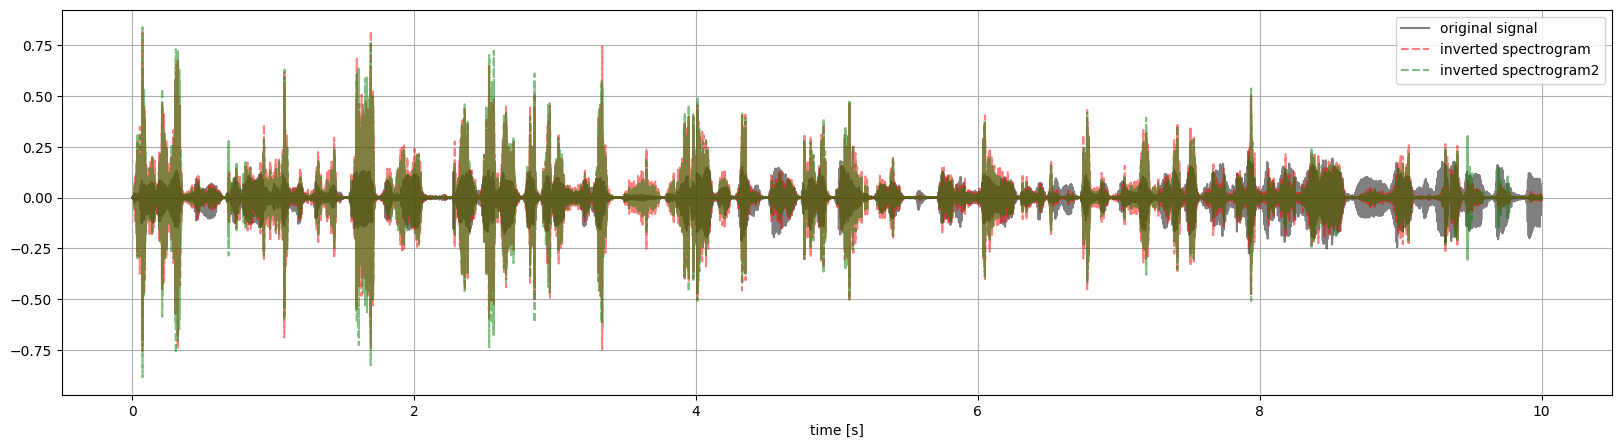

In [25]:
t_audio = np.arange(len(audio_signal)) * 1 / FS
plt.figure(figsize=(20, 5))
plt.plot(t_audio, audio_signal, label="original signal", color="black", alpha=.5)
plt.xlabel("time [s]")

t_mel = np.arange(len(mel_inversed)) * 1 / FS

plt.plot(
    t_mel, 
    mel_inversed,
    label="inverted spectrogram", 
    color ="red", 
    linestyle="dashed", 
    alpha=.5
)

plt.plot(
    t_mel, 
    mel_inversed2,
    label="inverted spectrogram2", 
    color ="green", 
    linestyle="dashed", 
    alpha=.5
)


# mel_filt = scipy.signal.savgol_filter(mel_inversed, 16, 2) 
# mel_filt *= (audio_signal.max() - audio_signal.min()) / (mel_filt.max() - mel_filt.min())

# plt.plot(
#     t_mel, mel_filt,
#     label="inverted spectrogram (filtered)", color ="blue", linestyle="dashed", alpha=.5
# ) 
plt.grid()
plt.legend()

sf.write(
    f"output/{NAME}.wav", audio_signal, FS, subtype='PCM_24'
)

# sf.write(
#     f"output/reconstructed_{NAME}_filt.wav", mel_filt, FS, subtype='PCM_24'
# )

sf.write(
    f"output/{OUTPUT_NAME}_ci.wav", mel_inversed, FS, subtype='PCM_24'
)

# sf.write(
#     f"output/{OUTPUT_NAME}_ci2.wav", mel_inversed2, FS, subtype='PCM_24'
# )


# n = int(np.ceil(mel_inversed.size * (16000 / FS)))
# mp3 = scipy.signal.resample(mel_inversed, n)
# sf.write(
#         f"output/reconstructed_{NAME}_ci.mp3", mp3, 16000,
#         format='MP3', subtype='MPEG_LAYER_III'
# )




In [26]:
np.linalg.norm(S - filtered_data), np.linalg.norm(S - smooth), np.linalg.norm(filtered_data - smooth)

(np.float64(49601.422629934765),
 np.float64(54503.13772983614),
 np.float64(5588.275491567895))

In [27]:
np.max(scipy.signal.correlate(audio_signal, mel_inversed, mode='full')), np.max(scipy.signal.correlate(audio_signal, mel_inversed2, mode='full'))

(np.float32(6.351808), np.float32(5.947628))

In [28]:
from skimage.metrics import structural_similarity as ssim

In [29]:
ssim(S, filtered_data, data_range = 80), ssim(S, smooth, data_range = 80), ssim(smooth, filtered_data, data_range = 80)

(np.float64(-4.891951327066637e-05),
 np.float64(-5.95484486856548e-05),
 np.float64(0.920704354009259))

In [30]:
def si_snr(preds: np.array, target: np.array):
    eps = np.finfo(preds.dtype).eps
    
    target = target - np.mean(target)
    preds = preds - np.mean(preds)
        
    noise = target - preds

    snr_value = (np.sum(target**2) + eps) / (np.sum(noise**2) + eps)
    return 10 * np.log10(snr_value)



si_snr(mel_inversed, audio_signal), si_snr(mel_inversed2, audio_signal), si_snr(audio_signal, audio_signal)

(np.float32(-6.0335474), np.float32(-6.1151485), np.float32(92.657005))